In [1]:
%pylab
%matplotlib inline

from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
def w_alpha(alpha,X,lambd): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + alpha[i]*X[i,:]/(lambd*n)
    return w

def dual_obj(w, alpha,X,y,lambd): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n):         
        da = da + alpha[i]*y[i] - 0.25*alpha[i]*alpha[i]
    da = da/float(n)
    da = da - 0.5*lambd*np.square(np.linalg.norm(w_alpha(alpha,X,lambd)))
    return da

def primal_func(w,alpha,X,y,lambd): # computes the primal value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        dif = np.dot(X[i,:],w) - y[i]
        pw = pw + dif*dif
    pw = pw/float(n)
    pw = pw + 0.5*lambd*np.square(np.linalg.norm(w))
    return pw

In [50]:
def dual_rigde(X,y, lambd, num_effective_passes,init_sample_size,obj = dual_obj, verbose=False):
  # each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  sq_row_norms =  np.square(np.linalg.norm(X, axis=1))
  n, d = X.shape
  rperm = np.random.permutation(n);
  alpha = np.zeros(n)
  w = w_alpha(alpha,X,lambd)
  obj_value = obj(w,alpha,X,y,lambd) 
  sample_size = init_sample_size
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
 
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0
  while completed_effective_passes < num_effective_passes:
#     if(completed_effective_passes>10.0):
#        sample_size = n
#     if(completed_effective_passes>30.0): 
#        lambd = 1.0/n     
    coords = rperm[np.random.permutation(sample_size)] 
    for ii in coords:
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        sqi = sq_row_norms[ii]
        yi = y[ii]
        # coordinate update step 
        delta_alpha_i = (yi- np.dot(xi,w)-0.5*alpha_i_old)/(0.5+sqi/(lambd*sample_size)) 
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*sample_size)
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(coords) / float(n)
    obj_value = obj(w,alpha,X,y,lambd)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("Obj[{}]= {},delta_alpha = {},sqi={}".format(completed_effective_passes, obj_value,(np.dot(xi,w)),sqi))
  return (alpha, stats,w)

In [56]:
def run_small_experiment(X,y,lambd,passes,plotname,primal_accuracy = False):
    num = 4
    rep = 4
    N,d = X.shape
    main_opt = 0
    clf = Ridge(alpha=lambd*N,fit_intercept=False)
    clf.fit(X, y)
    primal_opt =  primal_func(clf.coef_,0,X,y,lambd)
    print("primal obj={}".format(primal_opt))
    def dist_opt(w,alpha,X2,y2,lambd2):
      if primal_accuracy == True: 
        return primal_func(w,alpha,X2,y2,lambd) - primal_opt
      return primal_opt - dual_obj(w, alpha,X2,y2,lambd)
            #da = 0
            #for i in range(n): 
            #    if alpha[i] <= 1 and alpha[i] >= 0:
            #        da = da + alpha[i]
            #    else:
            #        da = da + float("inf")
            #da = da / n 
            #da = da - 0.5*lambd*np.square(((1.0*n)/N)*np.linalg.norm(w_alpha(alpha,A,lambd)))
            #return primal_opt - da
    (alpha_n,stats_n,w_n) = dual_rigde( X, y, 1.0/N, passes, obj = dist_opt,init_sample_size = N, verbose=True)
    t_randomperm, f_randomperm = get_data_plot(stats_n)  
    converge_rate = f_randomperm
    plabel = "lambd=1/n"
    plt.plot(t_randomperm,np.log(f_randomperm),label = plabel, marker='o')
#     inds = np.random.randint(N, size=n);
#     A = np.zeros((N,d))
#     X_sub = X[inds,:]
#     y_sub = y[inds]
    (alpha_f,stats_f,w_f) =dual_rigde( X,y, 1.5/N, passes, obj = dist_opt,init_sample_size = N, verbose=True)
    t_randomperm, f_randomperm = get_data_plot(stats_f)  
    converge_rate = f_randomperm
    plabel = "lambd=10/n"
    plt.plot(t_randomperm,np.log(f_randomperm),label = plabel, marker='o')
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname, facecolor='w', edgecolor='w', orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

primal obj=0.448450687754
 Initial objective value: 0.448450687754
Obj[1.0]= 0.418277444307,delta_alpha = -0.955573989929,sqi=14.0
Obj[2.0]= 0.390302200792,delta_alpha = -1.01328183001,sqi=13.0
Obj[3.0]= 0.36415928425,delta_alpha = -0.965599883065,sqi=14.0
Obj[4.0]= 0.339698505424,delta_alpha = -1.06595508537,sqi=13.0
Obj[5.0]= 0.316719703994,delta_alpha = -0.937434186216,sqi=14.0
Obj[6.0]= 0.295519994778,delta_alpha = 0.791473621067,sqi=14.0
Obj[7.0]= 0.27558314053,delta_alpha = -0.907029271335,sqi=14.0
Obj[8.0]= 0.256998948594,delta_alpha = -0.940938937977,sqi=14.0
Obj[9.0]= 0.239683745269,delta_alpha = -0.711969079814,sqi=14.0
Obj[10.0]= 0.223539660292,delta_alpha = -0.943085494807,sqi=14.0
Obj[11.0]= 0.208442764124,delta_alpha = 0.610278517981,sqi=14.0
Obj[12.0]= 0.194450530008,delta_alpha = -0.759537124072,sqi=14.0
Obj[13.0]= 0.181407351442,delta_alpha = -0.728240079877,sqi=14.0
Obj[14.0]= 0.169249000085,delta_alpha = 0.618810815612,sqi=14.0
Obj[15.0]= 0.157912178828,delta_alpha =

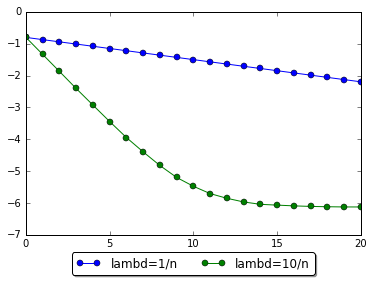

In [55]:
n = 32561; 
d = 123; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 20
alpha = run_small_experiment(X,y, lambd,passes,"plot/gisette_scale_primal.eps",primal_accuracy =False)

primal obj=0.449438705113
 Initial objective value: 0.550561294887
Obj[1.0]= 0.123597833046,delta_alpha = -1.30347047935,sqi=1.0
Obj[2.0]= 0.418994453631,delta_alpha = 0.402793241809,sqi=1.0
Obj[3.0]= 0.0268675217216,delta_alpha = 0.321546048254,sqi=1.0
Obj[4.0]= 0.0102838153502,delta_alpha = -1.17876691827,sqi=1.0
Obj[5.0]= 0.00467602867138,delta_alpha = -0.299902394629,sqi=1.0
Obj[6.0]= 0.00975067783259,delta_alpha = -0.282833069791,sqi=1.0
Obj[7.0]= 0.00328554207086,delta_alpha = -1.24033845978,sqi=1.0
Obj[8.0]= 0.00124302913418,delta_alpha = -1.05971904085,sqi=1.0
Obj[9.0]= 0.00112687762624,delta_alpha = -0.893867026198,sqi=1.0
Obj[10.0]= 0.000313357280788,delta_alpha = 0.965700813167,sqi=1.0
 Initial objective value: 0.550561294887
Obj[1.0]= 0.0316883064541,delta_alpha = -0.420125035937,sqi=1.0
Obj[2.0]= 0.00363441241391,delta_alpha = 0.00432128097016,sqi=1.0
Obj[3.0]= 0.000485508695041,delta_alpha = 0.418919676466,sqi=1.0
Obj[4.0]= 0.000295735840037,delta_alpha = 0.141385955283,s

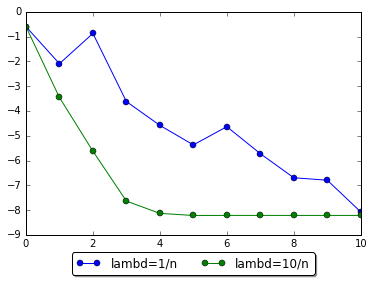

In [54]:
n = 32561; 
d = 123; 
import readsvm 

filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 10
alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_scale_dual.eps",primal_accuracy =True)

primal obj=0.0170737651357
 Initial objective value: 0.0170737651357
Obj[1.0]= 0.0170313080527,delta_alpha = 0.999964371443,sqi=4734.80287401
Obj[2.0]= 0.017006480073,delta_alpha = -0.999913197032,sqi=4651.39280976
Obj[3.0]= 0.0169869585013,delta_alpha = 1.00017086586,sqi=4635.88273367
Obj[4.0]= 0.0169695643194,delta_alpha = 0.999865451282,sqi=4601.24822789
Obj[5.0]= 0.0169539012395,delta_alpha = -1.00009775179,sqi=4607.78314123
Obj[6.0]= 0.0169394539968,delta_alpha = -1.00013875792,sqi=4627.6942918
Obj[7.0]= 0.0169254533949,delta_alpha = 1.00018855629,sqi=4607.50244305
Obj[8.0]= 0.0169123678006,delta_alpha = 1.00004256042,sqi=4668.98370134
Obj[9.0]= 0.0168995245705,delta_alpha = -1.00002302865,sqi=4624.1419285
Obj[10.0]= 0.01688725595,delta_alpha = -0.999852828069,sqi=4597.2706135
 Initial objective value: 0.0170737651357
Obj[1.0]= 0.0170203803413,delta_alpha = 0.999969026386,sqi=4711.17378456
Obj[2.0]= 0.0169896383002,delta_alpha = 0.999763231412,sqi=4640.28200306
Obj[3.0]= 0.0169651

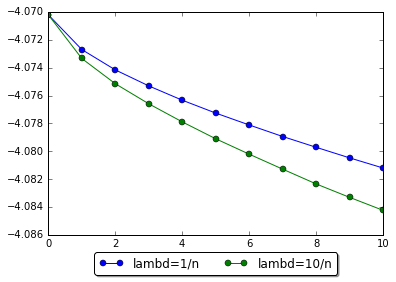

In [58]:
n = 6000; 
d = 5000; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/gisette_scale"
y, X = readfile(filename,n,d)
#X = preprocessing.scale(X)
lambd = 1.0/n
passes = 10
run_small_experiment(X,y, lambd,passes,"plot/gisette_scale_primal.eps",primal_accuracy = False)

primal obj=0.355197469316
 Initial objective value: 0.644802530684
Obj[1.0]= 1.0766500303,delta_alpha = -0.950230479826
Obj[2.0]= 0.516334096075,delta_alpha = -1.00715338
Obj[3.0]= 0.287211251329,delta_alpha = -1.00849150022
Obj[4.0]= 0.280982671126,delta_alpha = -1.0152683149
Obj[5.0]= 0.143980870424,delta_alpha = -1.00919326435
Obj[6.0]= 0.128320140835,delta_alpha = -1.09842405614
Obj[7.0]= 0.152711470914,delta_alpha = 0.357289735372
Obj[8.0]= 0.229884108907,delta_alpha = -0.581250413636
Obj[9.0]= 0.0969574985751,delta_alpha = -0.88617595834
Obj[10.0]= 0.0890921799579,delta_alpha = -0.936202135891
Obj[11.0]= 0.123618957249,delta_alpha = -0.626027555982
Obj[12.0]= 0.0891665795626,delta_alpha = -0.930246814615
Obj[13.0]= 0.0882981391016,delta_alpha = -0.861859827862
Obj[14.0]= 0.0716663778367,delta_alpha = -1.05091294007
Obj[15.0]= 0.105303825746,delta_alpha = -1.21972533957
Obj[16.0]= 0.0329427577864,delta_alpha = -0.976387033866
Obj[17.0]= 0.0685353858544,delta_alpha = -0.40922471996

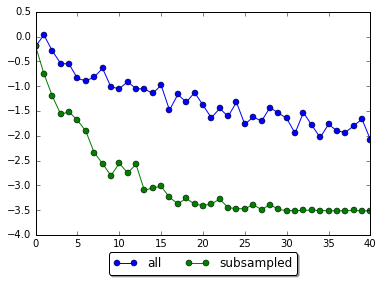

In [16]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
A = np.zeros((n,d))
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
lambd = 1.0/n
passes = 40
run_small_experiment(X,y,lambd,passes,"plot/w8a_primal.eps",primal_accuracy = True)

primal obj=0.355197469316
 Initial objective value: 0.355197469316
Obj[1.0]= 0.218744893871,delta_alpha = -0.991644213412
Obj[2.0]= 0.183519884426,delta_alpha = -0.624484201576
Obj[3.0]= 0.158094791264,delta_alpha = -0.924367237742
Obj[4.0]= 0.13858871651,delta_alpha = -1.02120979889
Obj[5.0]= 0.123152431501,delta_alpha = -0.943130889493
Obj[6.0]= 0.110612894352,delta_alpha = 0.953753998792
Obj[7.0]= 0.0999727176649,delta_alpha = -0.652352088122
Obj[8.0]= 0.0910213017823,delta_alpha = -0.938426317515
Obj[9.0]= 0.0831951694256,delta_alpha = -0.336996396686
Obj[10.0]= 0.0764380810828,delta_alpha = -0.921730072974
Obj[11.0]= 0.0705308321697,delta_alpha = -1.13950249968
 Initial objective value: 0.355197469316
Obj[1.0]= 0.125147813148,delta_alpha = -1.30047243632
Obj[2.0]= 0.0701305234893,delta_alpha = -0.952645688558
Obj[3.0]= 0.0485764225304,delta_alpha = -1.03322229177
Obj[4.0]= 0.0361541736186,delta_alpha = -0.889357301654
Obj[5.0]= 0.029595072903,delta_alpha = -0.377586771525
Obj[6.0]

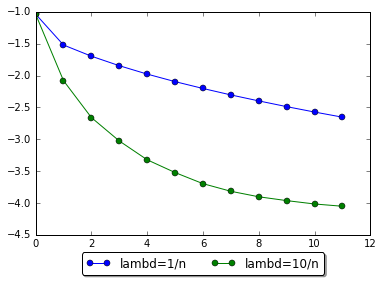

In [46]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 11
run_small_experiment(X,y,lambd,passes,"plot/w8a_primal.eps",primal_accuracy = False)

In [7]:
def distance_plot(X,y,n,d,lambd,nr,pivotsi,verbose = True):
    print(max(np.linalg.norm(X,axis =1 )))
    if(verbose):
        print("Loading Data Accomblished")
    indices = np.random.choice(n, pivotsi, replace=False)
    X = X[indices,:]
    y = y[indices]
    t1,t2 = X.shape
    print('t1:{},t2:{}'.format(t1,t2))
    for i in range(len(y)): 
        if y[i] == 2 :
            y[i] = -1
    n = pivotsi
    x0 = np.zeros(d)
    csize = 256
    sizes = [csize]
    while csize < (n/4.0):
        csize = 2* csize
        sizes.append(csize)
#     clf = Ridge(alpha=lambd*n,fit_intercept=False) 
    pivot = clf.fit(X, y).coef_
    pivot_primal = primal_func(pivot,0,X,y,lambd)
    print("precision:{},pivot_norm:{}".format(primal_func(pivot,0,X,y,lambd),np.square(np.linalg.norm(pivot))))
    spivot = str(pivot)[2:-2]
    
    dists= np.zeros((len(sizes),nr))
    angles = np.zeros((len(sizes),nr))
    for i in range(len(sizes)):
        subsamplsi = sizes[i]
        for j in range(nr):
            print('subsample size:{}'.format(subsamplsi))
            subindices = np.random.choice(n, subsamplsi, replace=False)
            lambd_s = 1.0/subsamplsi
            clf2 = Ridge(alpha=lambd_s*n,fit_intercept=False)
            clf2.fit(X, y)
            ws = clf2.coef_
            dist = primal_func(ws,0,X,y,lambd_s) - pivot_primal
            dists[i,j] = abs(dist)
            print("dist= {}".format(dists[i,j]))
        if(verbose):
          print("step: {}".format(i))   
    mdist = np.mean(dists,axis=1)
    vdist = np.var(np.log(dists),axis =1)
    print(vdist)
    sizes = np.divide(1.0,sizes)
    xd = np.log(sizes)
    yd = np.log(mdist)
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    mang = np.mean(angles,axis = 1)
    vang = np.var(angles,axis= 1)
    plt.errorbar(np.log(sizes),np.log(mdist),yerr=vdist)
    #plt.plot(np.log(sizes),np.log(mdist),marker='o')
    label_l = "y =%.2f x + %.2f" % (slope,intercept)
    print(label_l)
    plt.plot(xl,yl,label = label_l)
    plt.xlabel("Log(m)")
    plt.ylabel("Log(|P_m^* - P_n^*|)")
   # plt.title("Distance Plot For %s" % dataname)
    plt.legend()

In [8]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,4,n)

10.677078252
Loading Data Accomblished
t1:49749,t2:300
[[ -9.22408313e+00  -9.66403865e+00  -9.53657364e+00  -9.42384120e+00
   -1.10481854e+01  -7.03377015e+00  -8.81315805e+00  -7.02829533e+00
   -7.71994129e+00  -9.73240291e+00  -9.22470977e+00  -8.12318663e+00
   -7.02354509e+00  -8.40991462e+00  -8.12190280e+00  -1.05799448e+01
   -1.19246628e+00  -8.12588420e+00  -1.03554931e+01  -8.41965397e+00
   -1.15972817e+01  -8.11814689e+00  -9.66289671e+00  -8.96898217e+00
   -7.03062976e+00  -8.96874866e+00  -8.12522939e+00  -9.10369379e+00
   -8.12309554e+00  -9.42029566e+00  -8.12489991e+00  -8.81550631e+00
   -8.96979649e+00  -9.10368606e+00  -1.88861838e+00   3.73811272e-02
   -1.01463031e+00  -1.08075510e+00  -6.84776876e+00   3.79357253e+00
   -2.52001384e-01   7.10759269e+00   7.10759269e+00  -1.59496945e+00
   -6.51375885e-01   1.40405671e-01  -8.89786638e-01   2.79825286e+00
    6.78239213e+00  -1.69083096e-01  -6.80500337e-01  -3.56925964e+00
    1.28485081e+00  -8.40834373e-01

ValueError: shapes (300,) and (1,300) not aligned: 300 (dim 0) != 1 (dim 0)

3.74165738677
Loading Data Accomblished
t1:32561,t2:123
precision:0.448450687754,pivot_norm:1.977641904
subsample size:256
dist= 0.00285437647442
subsample size:256
dist= 0.00285437647442
subsample size:256
dist= 0.00285437647442
subsample size:256
dist= 0.00285437647442
step: 0
subsample size:512
dist= 0.00155789736637
subsample size:512
dist= 0.00155789736637
subsample size:512
dist= 0.00155789736637
subsample size:512
dist= 0.00155789736637
step: 1
subsample size:1024
dist= 0.000835541074371
subsample size:1024
dist= 0.000835541074371
subsample size:1024
dist= 0.000835541074371
subsample size:1024
dist= 0.000835541074371
step: 2
subsample size:2048
dist= 0.000432462650807
subsample size:2048
dist= 0.000432462650807
subsample size:2048
dist= 0.000432462650807
subsample size:2048
dist= 0.000432462650807
step: 3
subsample size:4096
dist= 0.000210723396291
subsample size:4096
dist= 0.000210723396291
subsample size:4096
dist= 0.000210723396291
subsample size:4096
dist= 0.000210723396291


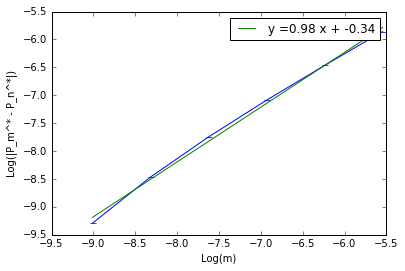

In [70]:
n = 32561; 
d = 123;
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,4,n)

2.74779987078
Loading Data Accomblished
t1:50100,t2:54
precision:0.48001585772,pivot_norm:41.6857160433
subsample size:256
dist= 0.0403006214755
subsample size:256
dist= 0.0403006214755
subsample size:256
dist= 0.0403006214755
subsample size:256
dist= 0.0403006214755
step: 0
subsample size:512
dist= 0.0265223458843
subsample size:512
dist= 0.0265223458843
subsample size:512
dist= 0.0265223458843
subsample size:512
dist= 0.0265223458843
step: 1
subsample size:1024
dist= 0.0159554943098
subsample size:1024
dist= 0.0159554943098
subsample size:1024
dist= 0.0159554943098
subsample size:1024
dist= 0.0159554943098
step: 2
subsample size:2048
dist= 0.008779064308
subsample size:2048
dist= 0.008779064308
subsample size:2048
dist= 0.008779064308
subsample size:2048
dist= 0.008779064308
step: 3
subsample size:4096
dist= 0.00448228209425
subsample size:4096
dist= 0.00448228209425
subsample size:4096
dist= 0.00448228209425
subsample size:4096
dist= 0.00448228209425
step: 4
subsample size:8192
dist

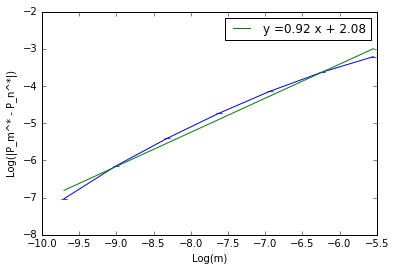

In [67]:
n = 50100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,4,n)

In [55]:
n

32561

In [56]:
m = np.dot(np.transpose(X),X)

In [57]:
w, v = np.linalg.eig(m)

In [58]:
w

array([  2.04733109e+05 +0.00000000e+00j,
         3.00060137e+04 +0.00000000e+00j,
         1.89760099e+04 +0.00000000e+00j,
         1.47775545e+04 +0.00000000e+00j,
         1.27689553e+04 +0.00000000e+00j,
         1.11075911e+04 +0.00000000e+00j,
         9.23128516e+03 +0.00000000e+00j,
         8.21859113e+03 +0.00000000e+00j,
         7.68821208e+03 +0.00000000e+00j,
         6.74632272e+03 +0.00000000e+00j,
         5.85950617e+03 +0.00000000e+00j,
         6.32331739e+03 +0.00000000e+00j,
         6.62255133e+03 +0.00000000e+00j,
         6.56298615e+03 +0.00000000e+00j,
         6.43950426e+03 +0.00000000e+00j,
         6.51137359e+03 +0.00000000e+00j,
         5.62619331e+03 +0.00000000e+00j,
         4.86403733e+03 +0.00000000e+00j,
         4.67723820e+03 +0.00000000e+00j,
         4.51735696e+03 +0.00000000e+00j,
         4.05828009e+03 +0.00000000e+00j,
         4.07288463e+03 +0.00000000e+00j,
         3.52254470e+03 +0.00000000e+00j,
         3.67894843e+03 +0.0000000

In [59]:
np.linalg.matrix_rank(m)

108

In [3]:
n = 32561; 
d = 123;
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)


In [4]:
 U, s, V = np.linalg.svd(X, full_matrices=False)

In [5]:
U.shape

(32561, 123)

In [6]:
X.shape

(32561, 123)

In [7]:
V.shape

(123, 123)

In [8]:
uy = np.dot(np.transpose(U),y)

In [10]:
np.dot(np.transpose(uy),uy)

17969.685843462219

(array([ 90.,  25.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.06082143e-13,   4.52474429e+01,   9.04948859e+01,
          1.35742329e+02,   1.80989772e+02,   2.26237215e+02,
          2.71484658e+02,   3.16732101e+02,   3.61979544e+02,
          4.07226987e+02,   4.52474429e+02]),
 <a list of 10 Patch objects>)

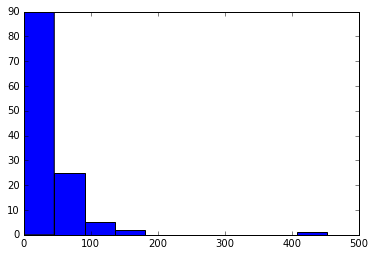

In [12]:
plt.hist(s)

In [14]:
max(s)

452.47442944940286